In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import networkx as nx
from copy import deepcopy

# ユーザー間の繋がりを可視化する。
NetworkXを使ったが、処理に時間がかかるため、2000年のデータだけ用いた。

ネットワークが複雑になりすぎて、つくレポ数の少ないレシピを削除してみたりしたが、図から意味を汲み取ることはできなかった。

In [3]:
# データを読み込む
post_column = ["recipe_id", "post_id"]
report_column = ["recipe_id", "report_id"]

post_id = pd.read_csv("/Users/tamuramasayuki/Desktop/3S/基礎プロジェクトB/programming/dataset/recipe/recipe2000.csv", 
                               names=post_column, usecols=[0, 1])
report_id = pd.read_csv("/Users/tamuramasayuki/Desktop/3S/基礎プロジェクトB/programming/dataset/report 2/report2000.csv", 
                               names=report_column, usecols=[0, 1])

In [224]:
post_id.head()

,recipe_id,post_id
0,1fd30d34da7ceae6252b037a930c07d8cdf93610,bff78b84a0a6178a5f0990e66390ccfad268805b
1,63efc126bac0ca6616dcab6f1602efce14672de2,bff78b84a0a6178a5f0990e66390ccfad268805b
2,6c428dd06b5f5c819ebeb5ae40ff6013a6f44c06,51659496bd54e92020f420ed09f36f708507c285
3,6711592fcdd6bf4b1b31f6c2db03675fefeb5a26,5ba305879fffb63a698291ce1920e4bee0aa927a
4,771af6f008b28ccbef276e0fb773c83e2e86d6ca,8924e64d40348ec953d0b0181e2cc81dca90d429


In [225]:
report_id.head()

,recipe_id,report_id
0,efda763dc255a181f63b333abed2f2a39705beb5,e0eb835abb1fe74215b7ba5476d3cf879daef2ce
1,0caad21c9630c106dd1f49f6fe8c7883b1677bb5,e0eb835abb1fe74215b7ba5476d3cf879daef2ce
2,53fac1059a0ed4d4e1e0ddabbb77d96e5094f1e8,fb6655ce2f4d759911fb66dbd759744ba3f73307
3,0aaf166ef7f1a15ce3856ff1022681022908f001,88fc7cfaf1f0943f335f953f7c9574c2af251473
4,0caad21c9630c106dd1f49f6fe8c7883b1677bb5,5f62d52b05e96a1e149ef4736fafe7896bfc4437


レシピidを主キーとして、レシピ投稿主とつくれぽ投稿者を結びつける。（同時につくれぽのないレシピを削除している）

In [226]:
# つくレポのデータにレシピのデータを結合する
df = pd.merge(post_id,report_id, on="recipe_id", how="right")

In [227]:
del df["recipe_id"]

In [228]:
df.head()

,post_id,report_id
0,5ba305879fffb63a698291ce1920e4bee0aa927a,398f0bf5b3fd937766d8984d0ef9db8b13b588b7
1,5ba305879fffb63a698291ce1920e4bee0aa927a,398f0bf5b3fd937766d8984d0ef9db8b13b588b7
2,4be7e52359a880fd4018a96e667d97653c1db360,45cc6ff9da7ca291f6f87062aca2e23946bb6582
3,0570f37ace58c8221a6931429e29ce385097bcfd,e0eb835abb1fe74215b7ba5476d3cf879daef2ce
4,0570f37ace58c8221a6931429e29ce385097bcfd,79bf453e4f9fe9da7fbd4a81cbf1c88b141de8b0


In [229]:
# データ数を確認する
print("sample size")
print("__________")
print(f"post_id   : {len(post_id)}")
print(f"report_id : {len(report_id)}")
print(f"df        : {len(df)}")
print("")
print("unique size")
print("__________")
print(f"post_id   : {len(df['post_id'].unique())}")
print(f"report_id : {len(df['report_id'].unique())}")

sample size
__________
post_id   : 4499
report_id : 4487
df        : 4487

unique size
__________
post_id   : 88
report_id : 3667


In [230]:
# 同じpost_idまとめる
vc = df['post_id'].value_counts(ascending=True) 

In [231]:
# つくレポ数が1しかないもののpost_idを抽出する
index = []
for i in range(len(vc)):
    if vc[i] == 1:
        index.append(vc.index[i])
    else:
        break;

In [232]:
# つくレポ数が100以下のもののpost_idを抽出する
index2 = []
for i in range(len(vc)):
    if vc[i] <= 100:
        index2.append(vc.index[i])
    else:
        break;

In [233]:
# それぞれの抽出した数を確認する
print("index:", len(index))
print("index2:", len(index2))

index: 30
index2: 82


dfから抽出したpost_idを削除する

In [234]:
record_index = []
for i in index:
    for j in range(len(df)):
        if df["post_id"][j] == i:
            record_index.append(j)

In [235]:
record_index2 = []
for i in index2:
    for j in range(len(df)):
        if df["post_id"][j] == i:
            record_index2.append(j)

In [236]:
df_drop1 = df.drop(record_index)
df_drop2 = df.drop(record_index2)

In [237]:
# NetworkXに読み込ませるため、列名を変更する
# sourceとtargetにしないと読み込めないらしい
df.rename(columns={'post_id': 'source', 'report_id': 'target'}, inplace=True)
df_drop1.rename(columns={'post_id': 'source', 'report_id': 'target'}, inplace=True)
df_drop2.rename(columns={'post_id': 'source', 'report_id': 'target'}, inplace=True)

In [249]:
# 確認
df_drop1["source"].value_counts()

ea3b51fa111eb6fd48f522140a9ee10c8dcf5521    1464
e40f88f70888037e1d9968623054ec95b2bce1b9    1161
edfd3b9eb0f3fa484952377ff243e948b3bc1c49     407
d3eb950e2bb29dd9822eb2db952c219fb42af595     344
e59a7e90ea23eae5e8fdcde4a2164e57a8ddc41a     281
3deac054094d1ece2690c96d22e0fe5be2e72aeb     106
43eaee8444a9ba0df6e28837d55b654ff44e3e2c      80
8f5dbd3778ccf8f10d21f785c3c2eb113844a621      56
b95fa5f265e8aaa3936ff0974e52871659f94662      53
03c82489d2ec5812d9ffe287e484c0f0161834f5      47
0570f37ace58c8221a6931429e29ce385097bcfd      47
7c8a8a28f77954affd7d429d7331da76d1628ff2      45
4a4c7513e842e62eafe530ba88a07e416121d6b5      40
3ca7df885ef93f6ee6c9181dc95a5900f2be9254      38
d7ceb1f47cd8e5ff06e33000e994ee08669447ae      28
9cea569d5d7094f4523ed33d9d4e5bccc1f4f650      22
bf2ebc582df1c8b39db606cbe6a7dbbf6ed60a9c      20
a0b5bcab054610f2da05c0bd9c64e0350bad809a      19
5c22c86ba95a1134081bc6aef3a22a2e6ca41ba8      17
abe9a5cacaf3a09ef1fac390233b7c5e2f0e3704      14
98cf032a7a97d1db0044

In [250]:
# 確認
df_drop2["source"].value_counts()

ea3b51fa111eb6fd48f522140a9ee10c8dcf5521    1464
e40f88f70888037e1d9968623054ec95b2bce1b9    1161
edfd3b9eb0f3fa484952377ff243e948b3bc1c49     407
d3eb950e2bb29dd9822eb2db952c219fb42af595     344
e59a7e90ea23eae5e8fdcde4a2164e57a8ddc41a     281
3deac054094d1ece2690c96d22e0fe5be2e72aeb     106
Name: source, dtype: int64

In [251]:
# NetworkXで可視化する準備
edges = df.loc[:, "source":"target"]
edges1 = df_drop1.loc[:, "source":"target"]
edges2 = df_drop2.loc[:, "source":"target"]

G = nx.from_pandas_edgelist(edges)
G1 = nx.from_pandas_edgelist(edges1)
G2 = nx.from_pandas_edgelist(edges2)

In [252]:
nx.number_of_nodes(G)

3755

In [253]:
nx.number_of_edges(G)

3926

In [254]:
# 可視化
pos = nx.spring_layout(G)

In [255]:
pos1 = nx.spring_layout(G1)

In [256]:
pos2 = nx.spring_layout(G2)

In [257]:
pr = nx.pagerank(G)
pr1 = nx.pagerank(G1)

In [258]:
pr2 = nx.pagerank(G2)

全てのデータを用いたネットワーク

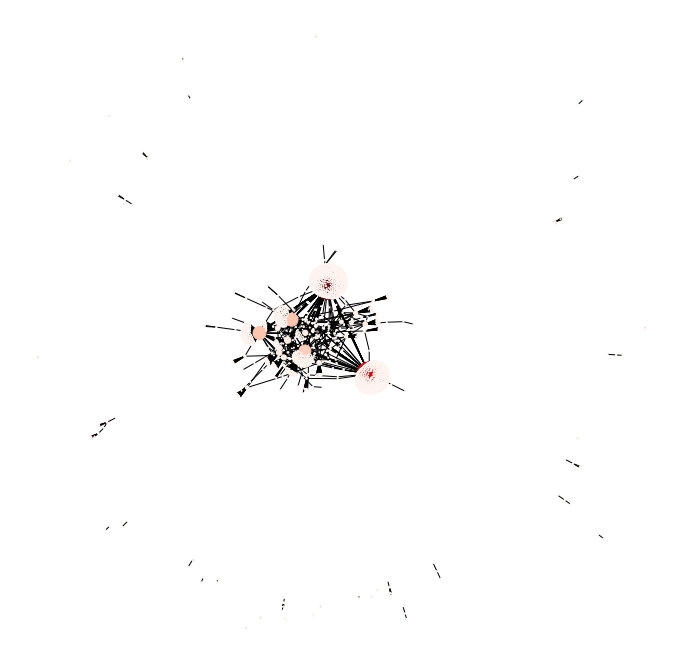

In [259]:
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_size=[5000*v for v in pr.values()], node_color=list(pr.values()), cmap=plt.cm.Reds)
plt.axis('off')
plt.show()

つくれぽ数が1のデータは省いたネットワーク

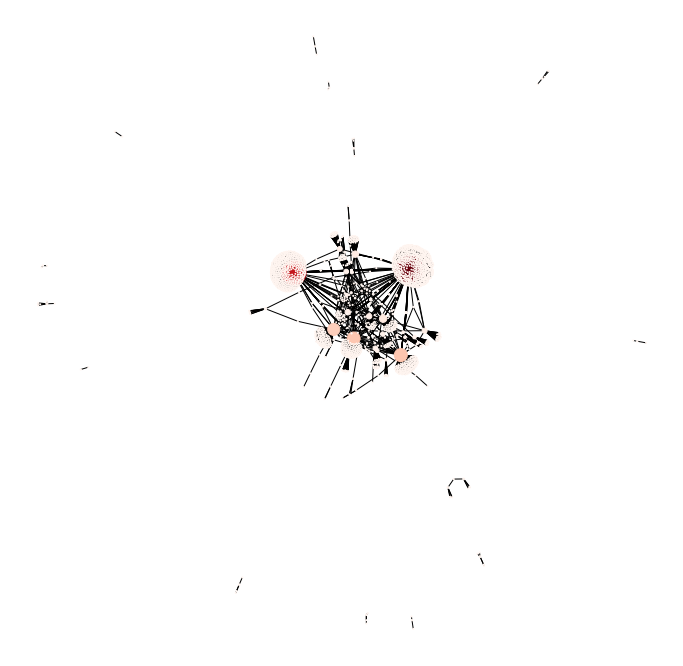

In [260]:
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G1, pos1)
nx.draw_networkx_nodes(G1, pos1, node_size=[5000*v for v in pr1.values()], node_color=list(pr1.values()), cmap=plt.cm.Reds)
plt.axis('off')
plt.show()

つくれぽ数が100以下のデータを省いたネットワーク（レシピは6個しかない）

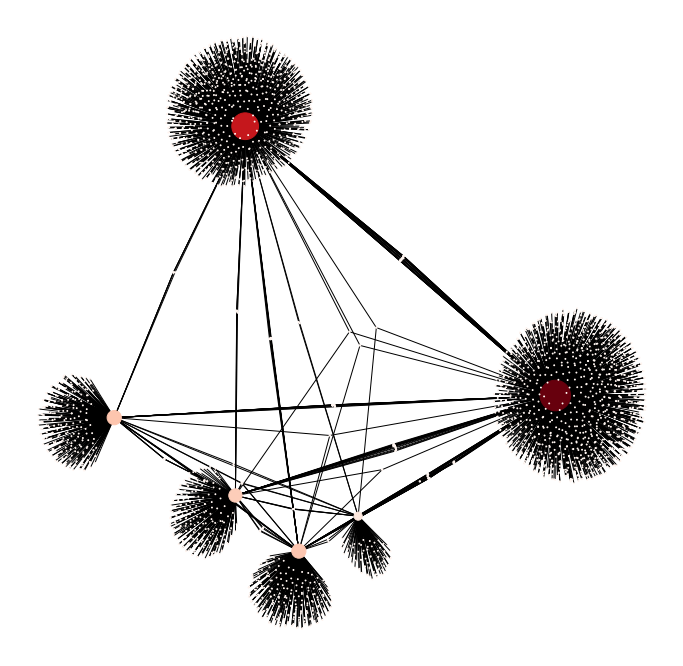

In [261]:
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G2, pos2)
nx.draw_networkx_nodes(G2, pos2, node_size=[5000*v for v in pr2.values()], node_color=list(pr2.values()), cmap=plt.cm.Reds)
plt.axis('off')
plt.show()